In [1]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from xgboost import plot_importance
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np
import time
import os

In [2]:
# Set option to display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.6f}'.format)

In [3]:
categorical_features = [
    "OP_CARRIER_AIRLINE_ID",
    "TAIL_NUM",
    "OP_CARRIER_FL_NUM",

    "ORIGIN_AIRPORT_ID",
    "ORIGIN_CITY_MARKET_ID",
    "ORIGIN_STATE_FIPS",
    "ORIGIN_WAC",
    "DEST_AIRPORT_ID",
    "DEST_CITY_MARKET_ID",
    "DEST_STATE_FIPS",
    "DEST_WAC",
]

numerical_features = [
    "QUARTER",
    "MONTH",
    "DAY_OF_MONTH",
    "DAY_OF_WEEK",

    "CRS_DEP_TIME",
    "DEP_TIME_BLK",
    "CRS_ARR_TIME", 
    "ARR_TIME_BLK",
    "CRS_ELAPSED_TIME",
    "DISTANCE",
    "DISTANCE_GROUP",
]

target = "DEP_DELAY_GROUP"

In [4]:
# Get the current script's directory
current_script_dir = os.getcwd()

# Move up to the parent directory
parent_dir = os.path.dirname(current_script_dir)

# Define the sibling data directory name
data_dir = os.path.join(parent_dir, 'data')

In [5]:
def set_categorical_dtype_to_str(
    dataframe: pd.DataFrame, 
    categorical_columns: list[str]
) -> pd.DataFrame:
    df = dataframe.copy()
    for column in categorical_columns:
        df[column] = df[column].astype('category')
    return df 

In [6]:
# Load the 2022 training datset
# Use os.path.join to create the full file path
training_dataset_filename = "encoded_training_dataset_2022.csv"
file_path = os.path.join(data_dir, training_dataset_filename)

# Read the CSV file into a DataFrame
dataset_df = pd.read_csv(file_path)
training_df = dataset_df[categorical_features+numerical_features+[target]].copy()

# Set dtype of categorical features to category
training_df = set_categorical_dtype_to_str(
    dataframe=training_df, 
    categorical_columns=categorical_features
)

# Display the DataFrame
display(training_df.describe())

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,DEP_DELAY_GROUP
count,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000
mean,2.525611,6.575482,15.731372,3.976177,1328.219585,8.024030,1486.236314,9.655784,143.059972,817.382685,3.740230,0.182563
std,1.103255,3.387474,8.757283,2.003274,491.535391,4.865378,519.240116,4.977613,72.606267,597.402761,2.341283,2.299142
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,31.000000,1.000000,-2.000000
25%,2.000000,4.000000,8.000000,2.000000,910.000000,4.000000,1101.000000,6.000000,90.000000,386.000000,2.000000,-1.000000
50%,3.000000,7.000000,16.000000,4.000000,1318.000000,8.000000,1512.000000,10.000000,125.000000,666.000000,3.000000,-1.000000
75%,3.000000,9.000000,23.000000,6.000000,1735.000000,12.000000,1921.000000,14.000000,174.000000,1052.000000,5.000000,0.000000
max,4.000000,12.000000,31.000000,7.000000,2359.000000,18.000000,2400.000000,18.000000,690.000000,5095.000000,11.000000,12.000000


In [7]:
# Function to score model using Huber Loss
def huber_loss(y_true, y_pred):
    delta = np.percentile(y_true, 95)
    huber_loss = np.mean(np.where(np.abs(np.array(y_true) -  np.array(y_pred)) <= delta, 
                                  0.5 * np.square(np.array(y_true) -  np.array(y_pred)), 
                                  delta * (np.abs(np.array(y_true) -  np.array(y_pred)) - 0.5 * delta)))
    return huber_loss
    
# Wrap the huber_loss function as a scorer for use in GridSearchCV
huber_scorer = make_scorer(huber_loss, greater_is_better=False)

# Make cross validation strategy
cv_strategy = KFold(n_splits=2, shuffle=True, random_state=123)

In [8]:
# Start timer
start_time = time.time()

param_dist = {
    'learning_rate': np.round(uniform.rvs(loc=0, scale=0.3, size=10), 2),
    'max_depth': randint(3, 11).rvs(size=8),
    'min_child_weight': randint(1, 11).rvs(size=10),
    'subsample': np.round(uniform.rvs(loc=0, scale=1, size=10), 2),
    'colsample_bytree': np.round(uniform.rvs(loc=0, scale=1, size=10), 2)
}

model = xgb.XGBRegressor(
    enable_categorical=True,
    objective='reg:pseudohubererror',
    random_state=123
)

random_search = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_dist,
    n_iter=100,              # Number of random parameter settings to try
    scoring=huber_scorer,
    cv=cv_strategy,          # 2-fold cross-validation
    n_jobs=-1,               # Use all available cores               
    verbose=2,
    random_state=123         # For reproducibility
)

# Fit the Random Search with the custom Huber loss as eval_metric
random_search.fit(
    training_df[categorical_features+numerical_features].values, 
    training_df[target].values
)

best_params = random_search.best_params_
print("Best parameters:", best_params)
print("Best Huber Loss Score:", -random_search.best_score_)

# End timer
end_time = time.time()
# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time} seconds")

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best parameters: {'subsample': np.float64(0.06), 'min_child_weight': np.int64(7), 'max_depth': np.int64(9), 'learning_rate': np.float64(0.26), 'colsample_bytree': np.float64(0.14)}
Best Huber Loss Score: 2.1086877147884087
Execution time: 486.48184847831726 seconds


In [9]:
param_grid = {
    'n_estimators': np.arange(100, 3001, 50),
}

model = xgb.XGBRegressor(
    enable_categorical=True,
    objective='reg:pseudohubererror',
    random_state=123,
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    min_child_weight=best_params['min_child_weight']
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=huber_scorer,
    cv=cv_strategy,          # 2-fold cross-validation
    n_jobs=-1,               # Use all available cores               
    verbose=2
)

grid_search.fit(
    training_df[categorical_features+numerical_features].values, 
    training_df[target].values
)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


GridSearchCV(cv=KFold(n_splits=2, random_state=123, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=np.float64(0.14),
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=True, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_ty...
                                    max_depth=np.int64(9), max_leaves=None,
                                    min_child_weight=np.int64(7), missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    objective='reg:pseudohubererror', ...),
             n_jobs=-1,
             param_grid={'n_estimators': array([ 25,  50,  75, 100, 125])},
             scoring=make_scorer(huber_loss, greater_is_better=False, response_method='predict'),
             verbose=2)

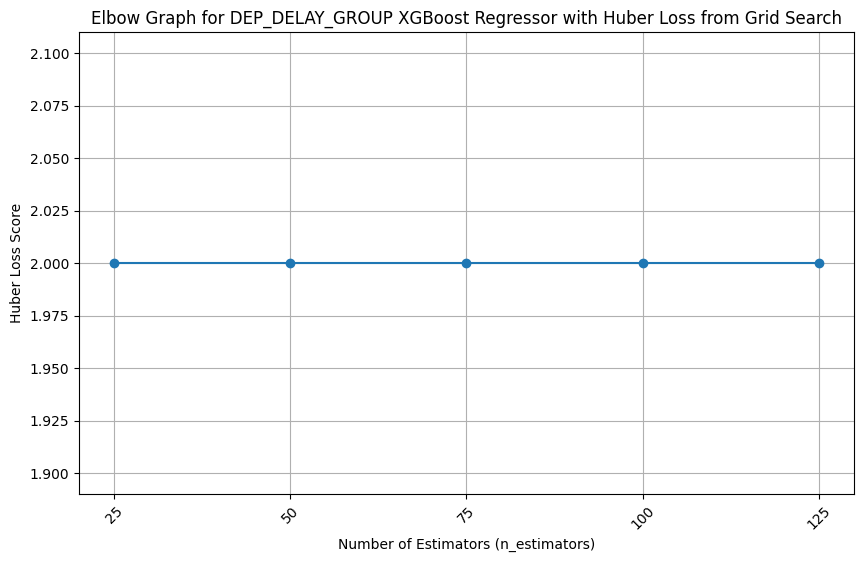

Best Parameters: {'n_estimators': np.int64(125)}
Best Huber Loss Score: 2.101720528242512


In [10]:
results = grid_search.cv_results_

score_values = np.round(-results['mean_test_score'])

plt.figure(figsize=(10, 6))
plt.plot(results['param_n_estimators'], score_values, marker='o')
plt.title('Elbow Graph for DEP_DELAY_GROUP XGBoost Regressor with Huber Loss from Grid Search')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Huber Loss Score')
plt.xticks(results['param_n_estimators'], rotation=45)
plt.grid()
plt.show()

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Huber Loss Score:", -grid_search.best_score_)

In [11]:
print(results['param_n_estimators'])

[25 50 75 100 125]


In [12]:
print(score_values)

[2. 2. 2. 2. 2.]
